In [1]:
## Run this in jupyter so any changes you make to the classes 
## will appear just by re-importing instead of having to re-start the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import numpy
import pandas as pd
import seaborn as sns
import random
import math
import os

from IPython import display

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
### Import model objects from their unique directories - easier to organize

from commuter_model.commuter_model import CommuterModel
from electrical_model.electrical_model import ElectricModel

## Build Commuter Model(s)

In [5]:
# load ipums data to local variable (ipums_df_19)
ipums_df_19 = pd.read_csv("commuter_model/disaggregated_cleaned_ipums_data.csv",index_col=0)
ipums_df_19 = ipums_df_19[ipums_df_19['YEAR']==2019].reset_index(drop=True).copy()

In [6]:
commuter_model_1 = CommuterModel(ipums_df=ipums_df_19)
## Run all the class methods and set equal to new commuter_model_1.ipums_df columns - just like you'd do in 
## our previous notebook attempts

### Changing some parameters
## Auto: unchanged
## Motorcycle: drastically decrease male/female pct, dropping max_age
## Taxicab: decreasing distance, dropping male/female pct
## Scooter: decreased male/female pct
## Auto
commuter_model_1.ipums_df['FLAG_AUTO'] = commuter_model_1.auto_flag_binary(
                                        max_age=70
                                       ,min_distance = 2
                                       ,min_income = 32626
                                       ,male_pct = 100
                                       ,female_pct = 100
                                       ,age_dist = None
                                       )
## Motorcycle
commuter_model_1.ipums_df['FLAG_MOTORCYCLE'] = commuter_model_1.motorcycle_flag_binary(
                                        max_age=40
                                       ,max_distance = 300
                                       ,min_income = 32626
                                       ,male_pct = 5
                                       ,female_pct = 1
                                       ,age_dist = None
                                        )


## Taxicab
commuter_model_1.ipums_df['FLAG_TAXICAB'] = commuter_model_1.taxicab_flag_binary(
                                        max_distance = 15
                                       ,min_income = 32626
                                       ,male_pct = 20
                                       ,female_pct = 20
                                       ,age_dist = None
                                        )

## Bus
commuter_model_1.ipums_df['FLAG_EBUSES'] = commuter_model_1.bus_flag_binary(
                                        home_region=commuter_model_1.puma_home_Bus
                                        ,work_region=commuter_model_1.puma_work_Bus
                                        ,schedule=commuter_model_1.time_Bus
                                        ,affordability=20
                                        ,fixgaps=False
                                         )


## Subway
commuter_model_1.ipums_df['FLAG_SUBWAY'] = commuter_model_1.subway_flag_binary(
                                            home_region=commuter_model_1.puma_home_Subway
                                            ,work_region=commuter_model_1.puma_work_Subway
                                            ,schedule=commuter_model_1.time_Subway
                                            ,affordability=20
                                            ,fixgaps=False
                                            )



## Commuter Rail
commuter_model_1.ipums_df['FLAG_COMMUTERRAIL'] = commuter_model_1.commuterRail_flag_binary(
                                             home_region=commuter_model_1.puma_home_CommuterRail
                                            ,work_region=commuter_model_1.puma_work_CommuterRail
                                            ,schedule=commuter_model_1.time_CommuterRail
                                            ,affordability=20
                                            ,fixgaps=False
                                            )

## Ferry
commuter_model_1.ipums_df['FLAG_FERRY'] = commuter_model_1.ferry_flag_binary(
                                            home_region=commuter_model_1.puma_home_Ferry
                                           ,work_region=commuter_model_1.puma_work_Ferry
                                           ,schedule=commuter_model_1.time_Ferry
                                           ,affordability=20
                                           ,fixgaps=False
                                          )



## E-Scooter
commuter_model_1.ipums_df['FLAG_ESCOOTER'] = commuter_model_1.escooter_flag_binary(
                                            max_age=60
                                            ,max_distance=3
                                            ,scooter_friendly_origins=commuter_model_1.bike_friendly_origins
                                            ,male_pct=10
                                            ,female_pct=5
                                            )


## Walking
commuter_model_1.ipums_df['FLAG_WALK'] = commuter_model_1.walking_flag_binary(
                                            max_age=100
                                            ,max_distance=2
                                            ,male_pct=100
                                            ,female_pct=100
                                            )

## E-Bike
commuter_model_1.ipums_df['FLAG_EBIKE']=commuter_model_1.ebike_flag_binary(
                                        max_age=70
                                        ,max_distance = 24
                                        ,male_pct = 100
                                        ,female_pct = 100
                                        ,age_dist = None
                                        ,bike_friendly_origins=commuter_model_1.bike_friendly_origins
                                        )


## Work From Home
commuter_model_1.ipums_df["FLAG_WFH"] = commuter_model_1.wfh_flag_binary(
                                            wfh_dampener=1
                                                )

In [15]:
## assign transmode given above flags
## first_assignment is of the ones somebody's eligible for, which do we pick?
## Then, for those that dont have any flags, we will use their existing TransMode 
## to pick a final ~TransMode~
commuter_model_1.ipums_df['First_Assignment'] = commuter_model_1.RandAssignNoOption(
                                                                commuter_model_1.ipums_df['FLAG_AUTO'], 
                                                                commuter_model_1.ipums_df['FLAG_MOTORCYCLE'],
                                                                commuter_model_1.ipums_df['FLAG_TAXICAB'], 
                                                                commuter_model_1.ipums_df['FLAG_EBUSES'],
                                                                commuter_model_1.ipums_df['FLAG_SUBWAY'], 
                                                                commuter_model_1.ipums_df['FLAG_COMMUTERRAIL'],
                                                                commuter_model_1.ipums_df['FLAG_FERRY'], 
                                                                commuter_model_1.ipums_df['FLAG_ESCOOTER'],
                                                                commuter_model_1.ipums_df['FLAG_WALK'], 
                                                                commuter_model_1.ipums_df['FLAG_EBIKE'],
                                                                commuter_model_1.ipums_df['FLAG_WFH'])
commuter_model_1.ipums_df['TransMode'] = commuter_model_1.RandAssignChosenOption(
                                                                commuter_model_1.ipums_df['First_Assignment'], 
                                                                commuter_model_1.ipums_df['MODE_TRANSP_TO_WORK_HBDMATCH'],
                                                                "Current")


## Commuter Model

In [16]:
### read in commuter_df. feed that and the ev file location to class
em_1 = ElectricModel(commuter_model_1.ipums_df
                     ,ev_reference_table_loc="electrical_model/EV_reference_table.csv"\
                    ,PEV_delay_hr=3,bus_ferry_cab_delay=6)
em_1

In [17]:
## Run methods in order to read in, clean, and aggregate data
em_1.read_electric_info_in()

em_1.clean_commuter_df()

em_1.create_in_out_flow_dfs()

em_1.aggregate_data()

ev reference table read in. subway floor and commuter rail floor extracted from table


### Trying some of J's visualizations

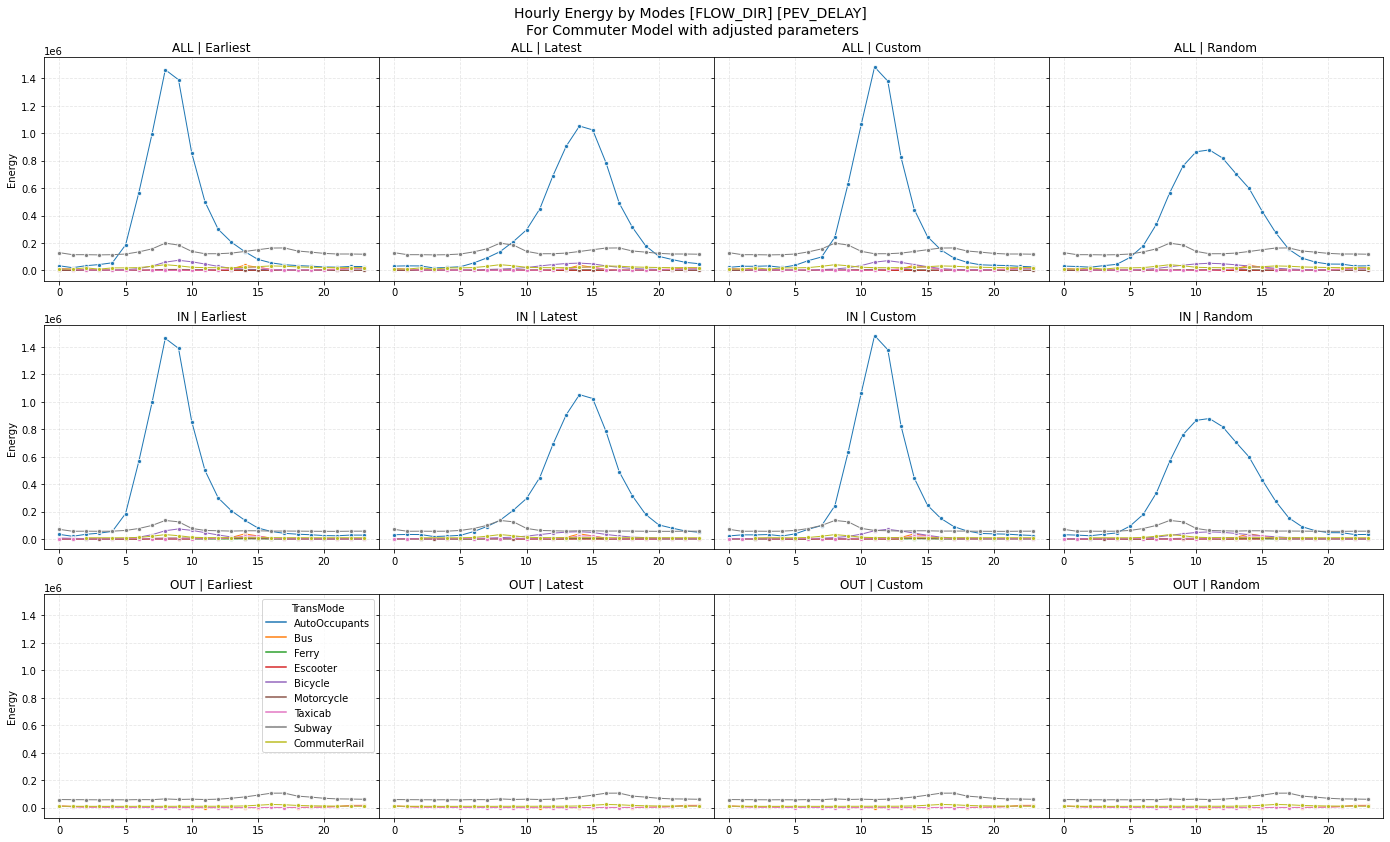

In [21]:
all_dir = em_1.df_aggregate.groupby(by=["Charge_Hour","TransMode","PEV_DELAY"]).agg({"Energy":"sum"}).reset_index()
all_dir['FLOW_DIR'] = 'ALL'
graphing_df = pd.concat([em_1.df_aggregate, all_dir]).reset_index(drop=True)

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(24,14),sharey=True)
plt.suptitle('Hourly Energy by Modes [FLOW_DIR] [PEV_DELAY] \nFor Commuter Model with adjusted parameters',x=0.5,y=0.93,fontsize=14)
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0,hspace=0.2)
dir_list = ['ALL','IN','OUT']
delay_list = ['Earliest','Latest','Custom','Random']
for i in range(3):
    for j in range(4):
        ax[i,j].grid(ls='--',alpha=0.3)
        sns.lineplot(data=graphing_df[(graphing_df['FLOW_DIR']==dir_list[i])\
                                      &(graphing_df['PEV_DELAY']==delay_list[j])]\
                     ,x='Charge_Hour',y='Energy',hue='TransMode',
                     linewidth=1,marker='o',markersize=4,ax=ax[i,j])
        if i != 2 or j!= 0:
            ax[i,j].legend([],[], frameon=False)
        ax[i,j].set_title(dir_list[i]+' | '+delay_list[j])
        ax[i,j].set(xlabel=None)